In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,
                             ConfusionMatrixDisplay, roc_auc_score, roc_curve, precision_recall_curve)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
# Load the dataset
url = '/content/train.csv'  # Replace with the dataset URL or upload it directly
df = pd.read_csv(url)

# Explore the dataset
print(df.head())
print(df.info())

   sl_no  gender  ssc_p    ssc_b  hsc_p    hsc_b     hsc_s  degree_p  \
0      1       0  67.00   Others  91.00   Others  Commerce     58.00   
1      2       0  79.33  Central  78.33   Others   Science     77.48   
2      3       0  65.00  Central  68.00  Central      Arts     64.00   
3      4       0  56.00  Central  52.00  Central   Science     52.00   
4      5       0  85.80  Central  73.60  Central  Commerce     73.30   

    degree_t workex  etest_p specialisation  mba_p      status    salary  
0   Sci&Tech     No     55.0         Mkt&HR  58.80      Placed  270000.0  
1   Sci&Tech    Yes     86.5        Mkt&Fin  66.28      Placed  200000.0  
2  Comm&Mgmt     No     75.0        Mkt&Fin  57.80      Placed  250000.0  
3   Sci&Tech     No     66.0         Mkt&HR  59.43  Not Placed       NaN  
4  Comm&Mgmt     No     96.8        Mkt&Fin  55.50      Placed  425000.0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215 entries, 0 to 214
Data columns (total 15 columns):
 #   Column 

In [ ]:
# Fill missing values in the salary column with the mean
df['salary'].fillna(df['salary'].mean(), inplace=True)

<ipython-input-7-117a3bc9378b>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['salary'].fillna(df['salary'].mean(), inplace=True)


<ipython-input-8-643e7999d08d>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='status', palette="Set2")


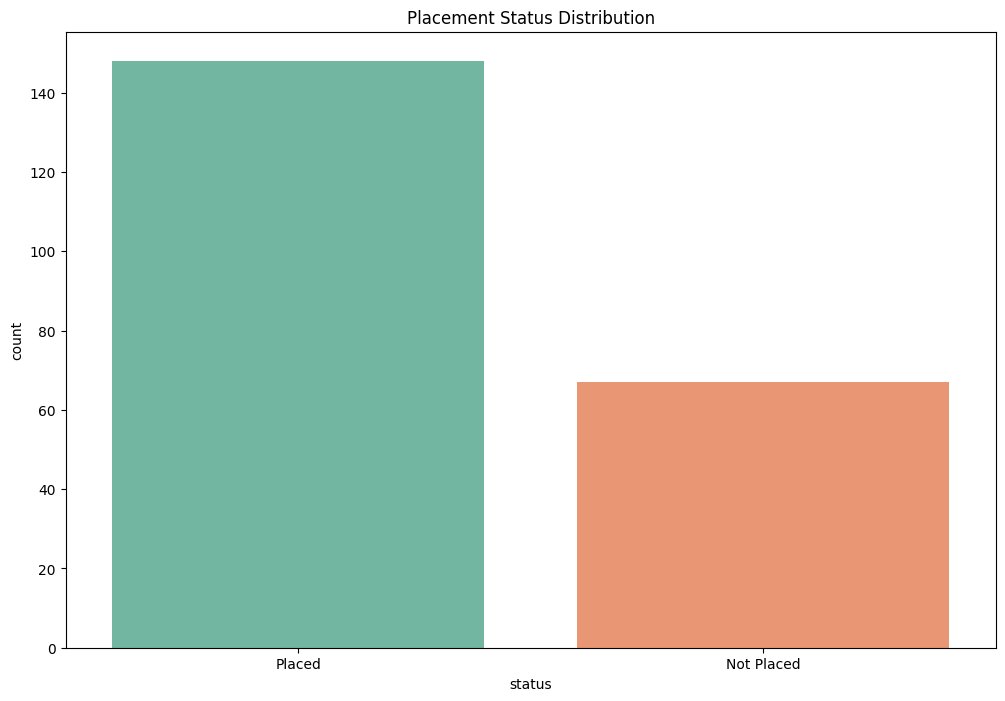

In [ ]:
# Visualize feature distributions
plt.figure(figsize=(12, 8))
sns.countplot(data=df, x='status', palette="Set2")
plt.title("Placement Status Distribution")
plt.show()

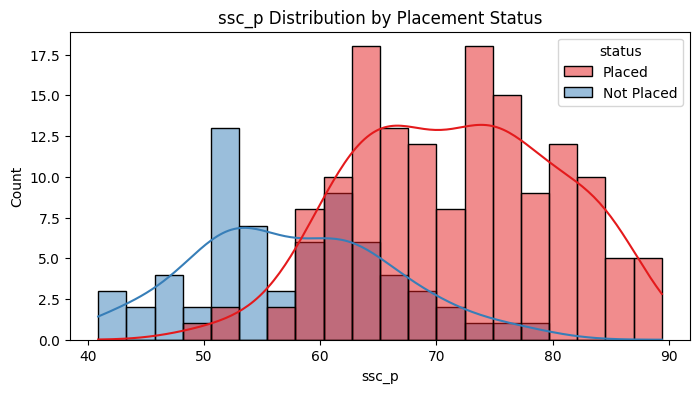

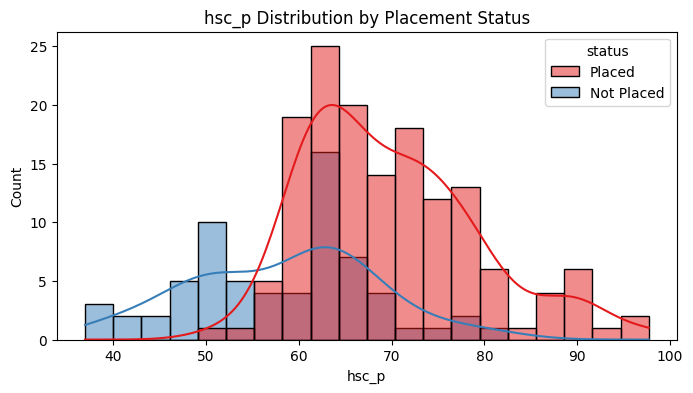

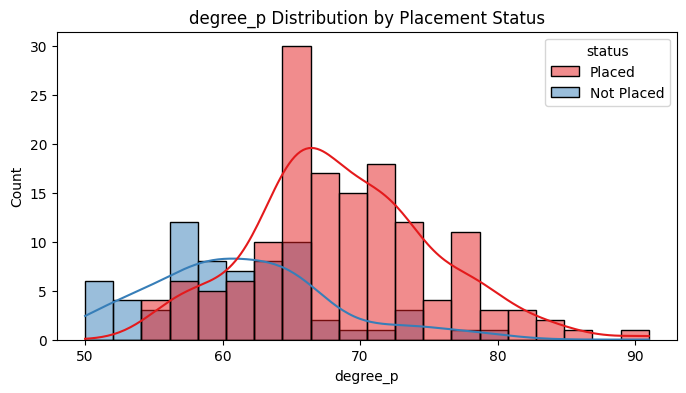

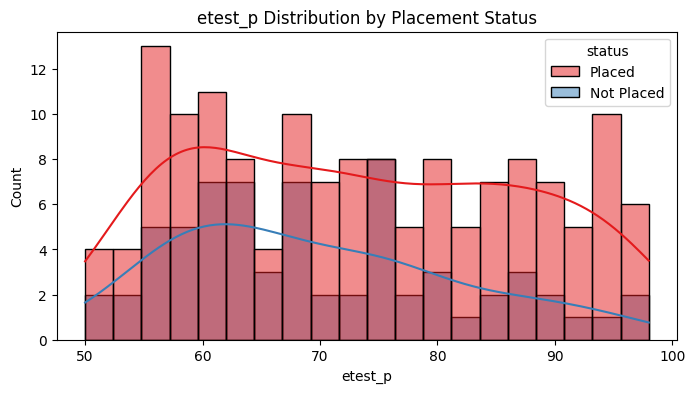

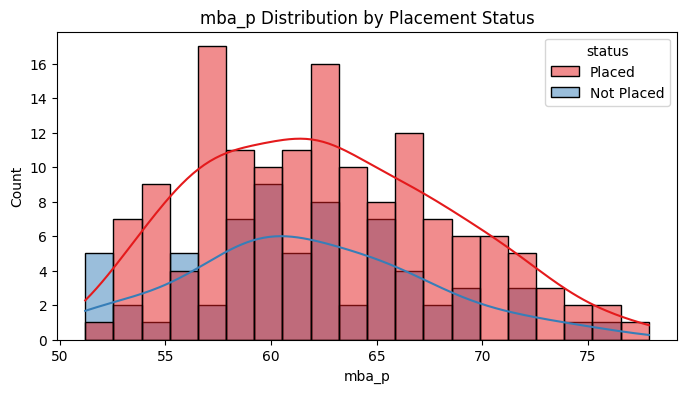

In [ ]:
# Check distribution of scores by placement status
for column in ['ssc_p', 'hsc_p', 'degree_p', 'etest_p', 'mba_p']:
    plt.figure(figsize=(8, 4))
    sns.histplot(data=df, x=column, hue="status", kde=True, palette="Set1", bins=20)
    plt.title(f"{column} Distribution by Placement Status")
    plt.show()

In [ ]:
# Feature Engineering
df['ssc_hsc_ratio'] = df['ssc_p'] / (df['hsc_p'] + 1)
df['ssc_degree_ratio'] = df['ssc_p'] / (df['degree_p'] + 1)
df['total_academic_score'] = df[['ssc_p', 'hsc_p', 'degree_p']].sum(axis=1)

In [ ]:
# Encode categorical features
label_encoders = {}
for column in ['gender', 'ssc_b', 'hsc_b', 'hsc_s', 'degree_t', 'specialisation', 'workex', 'status']:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

In [ ]:
# Split data into features and target variable
X = df.drop(['status'], axis=1)
y = df['status']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [ ]:
# Normalize numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# Define models with hyperparameter grids
models = {
    'Logistic Regression': (LogisticRegression(), {'C': [0.01, 0.1, 1, 10]}),
    'Decision Tree': (DecisionTreeClassifier(), {'max_depth': [3, 5, 7, 10]}),
    'Random Forest': (RandomForestClassifier(), {'n_estimators': [50, 100, 200], 'max_depth': [5, 10, 15]}),
    'SVM': (SVC(probability=True), {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}),
    'k-NN': (KNeighborsClassifier(), {'n_neighbors': [3, 5, 7]}),
    'Gradient Boosting': (GradientBoostingClassifier(), {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2]})
}

In [ ]:
# Train and tune models, then evaluate
model_results = {}
for model_name, (model, params) in models.items():
    grid = GridSearchCV(model, params, cv=5, scoring='f1')
    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)

    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1]) if hasattr(best_model, 'predict_proba') else None
    model_results[model_name] = {'Model': best_model, 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1 Score': f1, 'ROC AUC': auc}
model_results

{'Logistic Regression': {'Model': LogisticRegression(C=0.1),
  'Accuracy': 0.7538461538461538,
  'Precision': 0.7592592592592593,
  'Recall': 0.9318181818181818,
  'F1 Score': 0.8367346938775511,
  'ROC AUC': 0.9231601731601731},
 'Decision Tree': {'Model': DecisionTreeClassifier(max_depth=7),
  'Accuracy': 0.9846153846153847,
  'Precision': 1.0,
  'Recall': 0.9772727272727273,
  'F1 Score': 0.9885057471264368,
  'ROC AUC': 0.9886363636363636},
 'Random Forest': {'Model': RandomForestClassifier(max_depth=5, n_estimators=50),
  'Accuracy': 0.8923076923076924,
  'Precision': 0.8775510204081632,
  'Recall': 0.9772727272727273,
  'F1 Score': 0.9247311827956989,
  'ROC AUC': 0.9837662337662338},
 'SVM': {'Model': SVC(C=1, probability=True),
  'Accuracy': 0.8,
  'Precision': 0.7924528301886793,
  'Recall': 0.9545454545454546,
  'F1 Score': 0.865979381443299,
  'ROC AUC': 0.922077922077922},
 'k-NN': {'Model': KNeighborsClassifier(n_neighbors=7),
  'Accuracy': 0.7846153846153846,
  'Precision

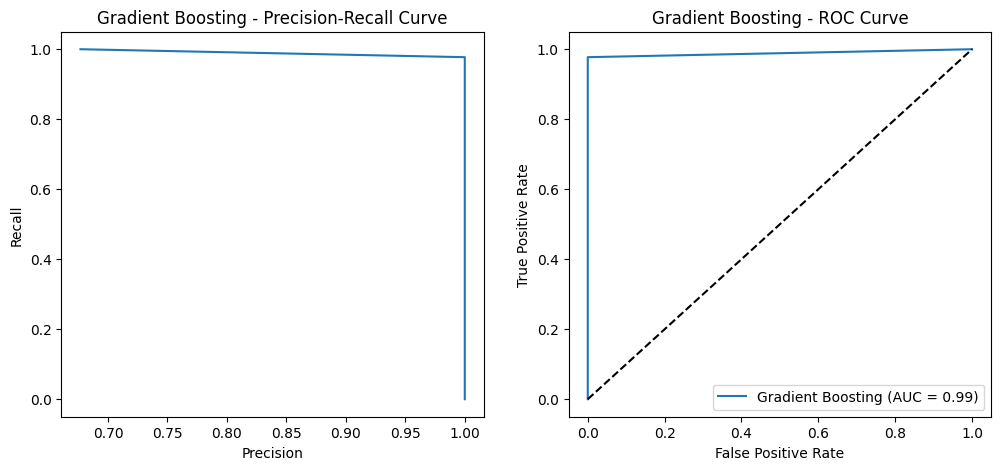

In [ ]:
# Precision-Recall and ROC Curves
if hasattr(best_model, 'predict_proba'):
        y_proba = best_model.predict_proba(X_test)[:, 1]
        precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_proba)
        fpr, tpr, _ = roc_curve(y_test, y_proba)

        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(precision_vals, recall_vals, label=f'{model_name}')
        plt.xlabel('Precision')
        plt.ylabel('Recall')
        plt.title(f'{model_name} - Precision-Recall Curve')

        plt.subplot(1, 2, 2)
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.2f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'{model_name} - ROC Curve')
        plt.legend()
        plt.show()

In [ ]:
# Display all model results
results_df = pd.DataFrame({k: v for k, v in model_results.items() if isinstance(v, dict)}).T.drop(columns='Model')
print("\nModel Performance Summary:\n", results_df)


Model Performance Summary:
                      Accuracy Precision    Recall  F1 Score   ROC AUC
Logistic Regression  0.753846  0.759259  0.931818  0.836735   0.92316
Decision Tree        0.984615       1.0  0.977273  0.988506  0.988636
Random Forest        0.892308  0.877551  0.977273  0.924731  0.983766
SVM                       0.8  0.792453  0.954545  0.865979  0.922078
k-NN                 0.784615  0.767857  0.977273      0.86   0.88961
Gradient Boosting    0.984615       1.0  0.977273  0.988506  0.988636


In [ ]:
# Weighted Voting Classifier using the best models
voting_clf = VotingClassifier(estimators=[(name, model['Model']) for name, model in model_results.items()],
                              voting='soft',
                              weights=[model['F1 Score'] for model in model_results.values()])
voting_clf.fit(X_train, y_train)
y_pred_voting = voting_clf.predict(X_test)

In [ ]:
# Voting Classifier metrics
accuracy_voting = accuracy_score(y_test, y_pred_voting)
precision_voting = precision_score(y_test, y_pred_voting)
recall_voting = recall_score(y_test, y_pred_voting)
f1_voting = f1_score(y_test, y_pred_voting)
auc_voting = roc_auc_score(y_test, voting_clf.predict_proba(X_test)[:, 1])

print(f"\nVoting Classifier Performance:\nAccuracy: {accuracy_voting}\nPrecision: {precision_voting}\nRecall: {recall_voting}\nF1 Score: {f1_voting}\nROC AUC: {auc_voting}")



Voting Classifier Performance:
Accuracy: 0.9846153846153847
Precision: 0.9777777777777777
Recall: 1.0
F1 Score: 0.9887640449438202
ROC AUC: 1.0
